In [1]:
from netCDF4 import Dataset
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime, timedelta
from scipy.stats import norm
import sys
sys.path.append(r'C:\Users\schijven\Documents\Classes\Input_preparation\lib')
from scipy.interpolate import griddata

C:\Users\schijven\AppData\Local\Temp\ipykernel_12168\4070340739.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%load_ext autoreload
%autoreload 2
from input_preparation_new import Input_prep

## Load the weights

In [105]:
model_root = Path(r"P:\11207365-eoatsee\Sofie\Data\Saved_models")
# model_schev = tf.keras.models.load_model(model_root / "Scheveningen/Scheveningen_full.keras")
model_vlis = tf.keras.models.load_model(model_root / "Vlissingen/Vlissingen_full.keras")
# model_eur = tf.keras.models.load_model(model_root / "Europlatform/Europlatform_full.keras")
weights = model_vlis.get_weights()
w1 = weights[0]

In [106]:
size_era5 = 1498
size_alt = 514
full_48 = 3*size_era5+4*size_alt

p = np.zeros((size_alt*48, 32))
u = np.zeros((size_alt*48, 32))
v = np.zeros((size_alt*48, 32))
dt = np.zeros((size_alt*48, 32))

for j in range(32):
    w1_new = w1[:,j]
    for i in range(48):
        p_new = w1_new[full_48*i + 3*size_era5 : full_48*i + 3*size_era5+size_alt]
        u_new = w1_new[full_48*i + 3*size_era5+size_alt : full_48*i + 3*size_era5+2*size_alt]
        v_new = w1_new[full_48*i + 3*size_era5+2*size_alt : full_48*i + 3*size_era5+3*size_alt]
        dt_new = w1_new[full_48*i + 3*size_era5+3*size_alt : full_48*i + full_48]
        p[i*size_alt:(i+1)*size_alt,j] += p_new
        u[i*size_alt:(i+1)*size_alt,j] += u_new
        v[i*size_alt:(i+1)*size_alt,j] += v_new
        dt[i*size_alt:(i+1)*size_alt,j] += dt_new

## Get locations for training data

In [107]:
config_filename = Path(r"C:\Users\schijven\Documents\Data\config.yaml")
test = Input_prep(config_filename)
tg_data, tg_t = test.load_tide_gauge_data_and_clip()
alt_clipped = test.load_alt_data_and_clip()
era5_data, era5_data_t = test.load_era_data_and_clip()

INFO:root:Reading configuration file C:\Users\schijven\Documents\Data\config.yaml...
INFO:root:Preparing data with clip interval 2001-07-01 00:00:00 - 2018-09-07 23:00:00. Timewindow = 48.
INFO:root:Tide gauge data from Vlissingen loaded and clipped
INFO:root:Altimetry data loaded and clipped
INFO:root:ERA5 data loaded and clipped


In [108]:
import logging
logging.disable(logging.DEBUG)

In [109]:
data = np.load(Path(r"C:\Users\schijven\Documents\Data\Altimetry_full.npy"), allow_pickle=True)
data_df = pd.DataFrame(data, columns=['Time', 'MSS', 'MDT', 'bias', 'SLA', 'SSB', 'OT', 'ST', 'PT', 'DAC',
                   'SWH', 'sigma', 'lats', 'lons', 'udist_vlis', 'udist_schev', 'udist_eur', 'vdist_vlis', 'vdist_schev', 'vdist_eur',
                    'mission', 'track', 'cycle', 'geoid', 'DOT'])
data_df.drop(columns=["MSS", "MDT", "bias", "SLA", "SSB", "OT", "ST", "PT", "DAC", "SWH", "sigma",
                     "mission", "track", "cycle", "geoid"], inplace=True)

data_clipped = data_df[(data_df.Time >= datetime(2001, 7, 1) - timedelta(hours=48)) & (data_df.Time <= datetime(2018, 9, 7, 23) - timedelta(hours=1))]
data_clipped.reset_index(drop=True, inplace=True)

In [8]:
training = []
for start_time in tqdm(era5_data_t):
            end_time = start_time + timedelta(hours=1)
            selected_data = data_clipped[(data_clipped.Time >= start_time) & (data_clipped.Time < end_time)].copy()
            training.append(selected_data)
lats = np.array([sample.lats.values for sample in training], dtype=object)
lons = np.array([sample.lons.values for sample in training], dtype=object)
lats_nan = np.array([np.nan_to_num(x, nan=0.0) for x in lats], dtype=object)
lats_padded = tf.keras.preprocessing.sequence.pad_sequences(lats_nan, padding='post', dtype='float32', value=0.0)
lons_nan = np.array([np.nan_to_num(x, nan=0.0) for x in lons], dtype=object)
lons_padded = tf.keras.preprocessing.sequence.pad_sequences(lons_nan, padding='post', dtype='float32', value=0.0)

100%|██████████| 150719/150719 [55:15<00:00, 45.45it/s] 


In [115]:
# skips_schev = np.array([3, 4, 7, 9, 10, 12, 16, 17, 21, 23, 25, 26])
skips_vlis = np.array([0, 18, 28])
# skips_eur = np.array([5, 6, 9, 15, 19, 23, 31])
neurons = np.arange(0, 32, 1)
n_test = np.isin(neurons, skips_vlis, invert=True)

In [116]:
lats_unique = data_clipped.lats.unique()
lons_unique = data_clipped.lons.unique()
counts = data_clipped.lons.value_counts(sort=False)

## Plot weights per hour

In [117]:
hour1 = 0
hour48 = 47

p_1 = p[514*hour1:514*(hour1+1),:]
p_48 = p[514*hour48:514*(hour48+1),:]

u_1 = u[514*hour1:514*(hour1+1),:]
u_48 = u[514*hour48:514*(hour48+1),:]

v_1 = v[514*hour1:514*(hour1+1),:]
v_48 = v[514*hour48:514*(hour48+1),:]

p1 = np.zeros(514)
p48 = np.zeros(514)

u1 = np.zeros(514)
u48 = np.zeros(514)

v1 = np.zeros(514)
v48 = np.zeros(514)

for i in range(32):
    if n_test[i]:
        p1 += p_1[:,i]
        p48 += p_48[:,i]
        u1 += u_1[:,i]
        u48 += u_48[:,i]
        v1 += v_1[:,i]
        v48 += v_48[:,i]
p1.shape, p48.shape

((514,), (514,))

In [119]:
# Create the repeated array
w_p1 = np.repeat([p1], lats_padded.shape[0], axis=0)
w_p48 = np.repeat([p48], lats_padded.shape[0], axis=0)

w_u1 = np.repeat([u1], lats_padded.shape[0], axis=0)
w_u48 = np.repeat([u48], lats_padded.shape[0], axis=0)

w_v1 = np.repeat([v1], lats_padded.shape[0], axis=0)
w_v48 = np.repeat([v48], lats_padded.shape[0], axis=0)

# Initialize the result array
wp1 = np.zeros(lats_unique.shape[0])
wp48 = np.zeros(lats_unique.shape[0])
wu1 = np.zeros(lats_unique.shape[0])
wu48 = np.zeros(lats_unique.shape[0])
wv1 = np.zeros(lats_unique.shape[0])
wv48 = np.zeros(lats_unique.shape[0])

# Use vectorized operations to sum values for each unique latitude
for i in tqdm(range(len(lats_unique))):
    l = lats_unique[i]
    mask = (lats_padded == l)
    wp1[i] = np.sum(w_p1[mask])
    wp48[i] = np.sum(w_p48[mask])
    wu1[i] = np.sum(w_u1[mask])
    wu48[i] = np.sum(w_u48[mask])
    wv1[i] = np.sum(w_v1[mask])
    wv48[i] = np.sum(w_v48[mask])

100%|██████████| 10699/10699 [28:52<00:00,  6.18it/s]


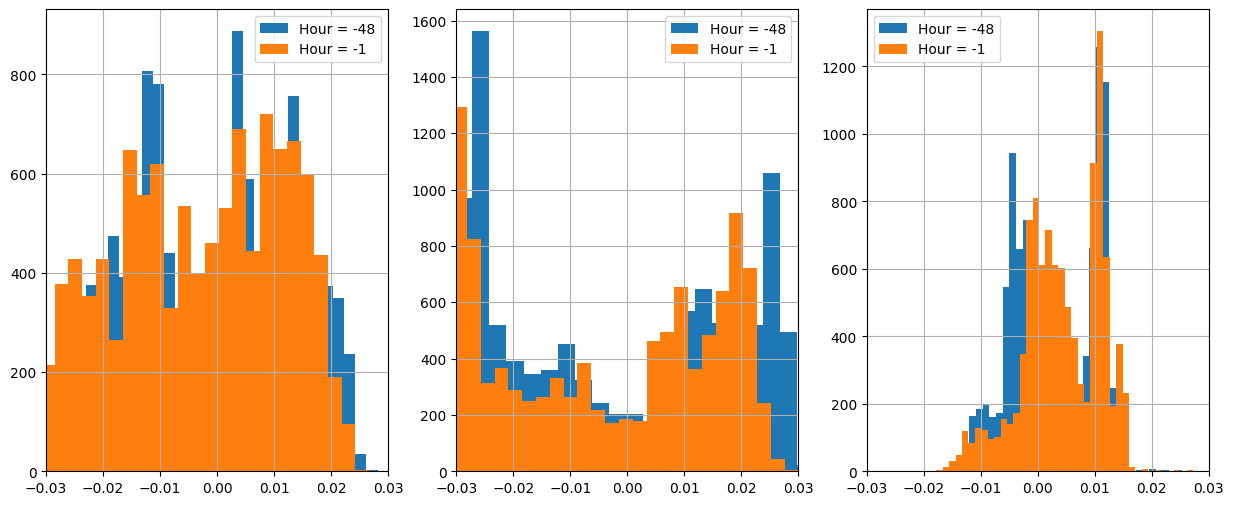

In [57]:
# Histograms

plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.hist(wp1/counts/np.sum(n_test), bins=200, label="Hour = -48")
plt.hist(wp48/counts/np.sum(n_test), bins=200, label="Hour = -1")
plt.legend()
plt.xlim(-0.03, 0.03)
plt.grid()

plt.subplot(1,3,2)
plt.hist(wu1/counts/np.sum(n_test), bins=200, label="Hour = -48")
plt.hist(wu48/counts/np.sum(n_test), bins=200, label="Hour = -1")
plt.legend()
plt.xlim(-0.03, 0.03)
plt.grid()

plt.subplot(1,3,3)
plt.hist(wv1/counts/np.sum(n_test), bins=200, label="Hour = -48")
plt.hist(wv48/counts/np.sum(n_test), bins=200, label="Hour = -1")
plt.legend()
plt.xlim(-0.03, 0.03)
plt.grid()

plt.show()

In [121]:
def plot_map(lons, lats, weights, counts, n, ax, fig, fontsize, limit=0.03):
    projection_crs = ccrs.Robinson()
    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.BORDERS, edgecolor='k')
    ax.add_feature(cfeature.OCEAN)
    ax.set_extent([-4.5, 9, 48, 60.5], crs=ccrs.PlateCarree())
    x = [-4, 4]
    y = [60, 60]
    x1 = [8.5, 4]
    y1 = [53.5, 60]
    x2 = [-1, 8.5]
    y2 = [48.5, 53.5]
    x3 = [-1, -4]
    y3 = [51, 57]
    x4 = [-4, -4]
    y4 = [60, 57]
    x5 = [-1, -1]
    y5 = [51, 48.5]
    ijx = [5, 5, 5.5, 5.5, 5]
    ijy = [53, 52.5, 52.5, 53, 53]
    ax.plot(x, y, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(ijx, ijy, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x1, y1, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x2, y2, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x3, y3, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x4, y4, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x5, y5, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, linewidth=1, xlabel_style={"size": fontsize}, ylabel_style={"size": fontsize}, color='gray', linestyle="dashed", alpha=0.5, x_inline=False)
    hb = ax.hexbin(lons, lats, gridsize=40, mincnt=1, reduce_C_function=np.mean, C=weights/counts/n, vmin=-limit, vmax=limit, cmap='Spectral_r', transform=ccrs.PlateCarree())
    cbar = fig.colorbar(hb, ax=ax, orientation='vertical', pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    return

Text(0.5, 1.0, 'Hour: -48')

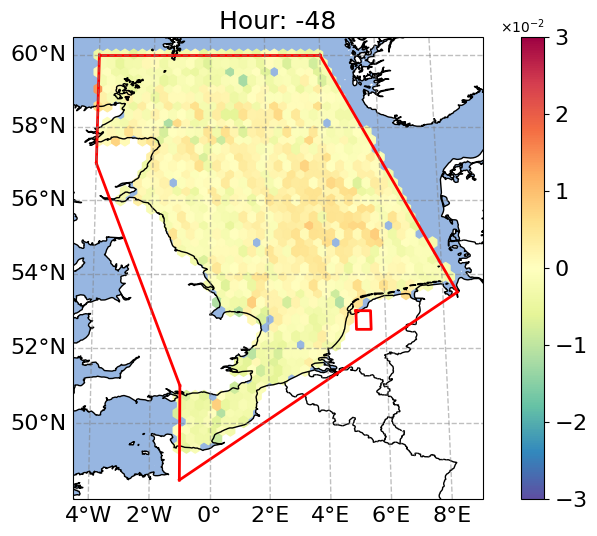

In [137]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10, 6))
plot_map(lons_unique.astype("float"), lats_unique.astype("float"), wv1, counts, np.sum(n_test), ax, fig, fontsize=16)
ax.set_title(f"Hour: {-48}", fontsize=18)

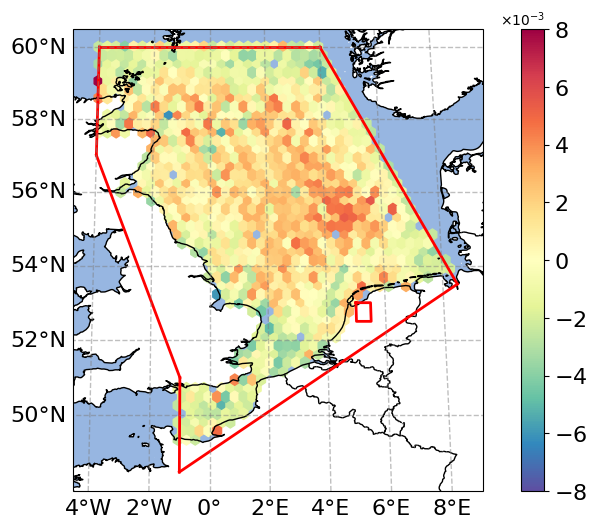

In [124]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10, 6))
plot_map(lons_unique.astype("float"), lats_unique.astype("float"), abs(wp48) - abs(wp1), counts, np.sum(n_test), ax, fig, fontsize=16, limit=0.008)
# ax.set_title(f"Hour: {-48}", fontsize=18)

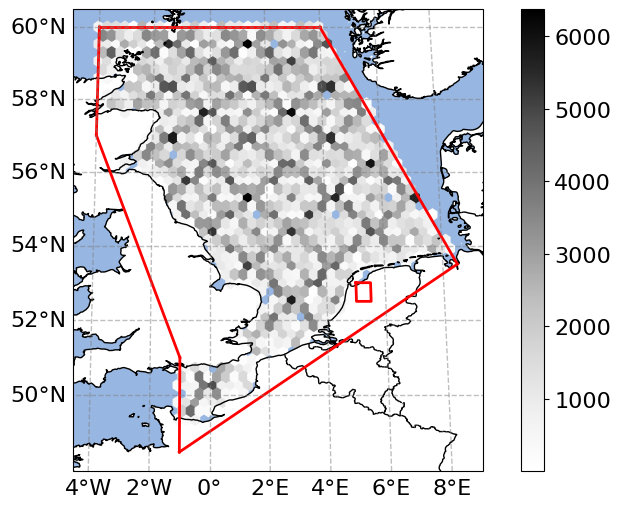

In [135]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(10, 6))
projection_crs = ccrs.Robinson()
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, edgecolor='k')
ax.add_feature(cfeature.OCEAN)
ax.set_extent([-4.5, 9, 48, 60.5], crs=ccrs.PlateCarree())
x = [-4, 4]
y = [60, 60]
x1 = [8.5, 4]
y1 = [53.5, 60]
x2 = [-1, 8.5]
y2 = [48.5, 53.5]
x3 = [-1, -4]
y3 = [51, 57]
x4 = [-4, -4]
y4 = [60, 57]
x5 = [-1, -1]
y5 = [51, 48.5]
ijx = [5, 5, 5.5, 5.5, 5]
ijy = [53, 52.5, 52.5, 53, 53]
ax.plot(x, y, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(ijx, ijy, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x1, y1, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x2, y2, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x3, y3, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x4, y4, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x5, y5, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, linewidth=1, xlabel_style={"size": 16}, ylabel_style={"size": 16}, color='gray', linestyle="dashed", alpha=0.5, x_inline=False)
hb = ax.hexbin(data_clipped.lons.values.astype("float"), data_clipped.lats.values.astype("float"), gridsize=40, mincnt=1, reduce_C_function=np.sum, cmap='Greys', transform=ccrs.PlateCarree())
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', pad=0.05)
cbar.ax.tick_params(labelsize=16)
# cbar.formatter.set_powerlimits((0, 0))
# cbar.formatter.set_useMathText(True)